# Neural Machine Translation by Jointly Learning to Align and Translate
#### 220220018 천호진


## 1. Introduction

신경망 기계 번역의 대다수는 인코더-디코더 구조로 되어 있다. 인코더는 입력되는 source 문장을 고정된 길이의 벡터로 인코딩하고, 디코더는 인코딩된 벡터로부터 번역된 문장을 출력하는 방식이다. 이러한 인코더-디코더 방식에서는 신경망이 source 문장의 모든 정보를 고정된 길이의 벡터로 압축할 수 있어야 하는데, 이 때문에 긴 문장을 다루는 데 어려움이 있다.<br><br>
이 문제를 해결하기 위해 저자는 개선된 인코더-디코더 모델을 제안했다. 제안된 모델은 한 단어를 번역할 때마다 해당 단어와 가장 관련있는 정보가 source 문장의 어디에 있는지(source position)를 탐색한다. 그 후 모델은 source position에 해당하는 context vector와 이전에 번역한 모든 target words에 기반하여 다음 target word를 예측한다.<br><br>
기본적인 인코더-디코더 모델과는 달리 제안된 모델은 인코더가 문장의 모든 정보를 하나의 고정된 길이의 벡터로 인코딩할 필요가 없다는 것이다. 저자는 이 모델이 긴 문장을 더 잘 다룬다는 것을 보였다.

In [1]:
#Colab 사용을 위한 준비
#torchtext.legacy 사용을 위해 torchtext를 0.11.0으로 downgrade
!pip install torchtext==0.11.0
#영어, 독일어 spacy 모델을 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 1.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

반복 실행시 동일한 결과를 얻을 수 있도록 random seed를 지정한다.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

독일어, 영어 spaCy 모델을 로드한다.<br><br>
spaCy는 토큰화(말뭉치를 단어와 문장부호 하나하나로 분해하는 것)와 품사 태깅(단어의 품사가 무엇인지 알려주는 것) 등의 기능을 지원하는 라이브러리이다. 이 코드에서는 영어, 독일어 말뭉치를 토큰화하기 위해 spaCy 모델을 사용하였다.

In [4]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

spaCy 모델을 사용하여 tokenizer를 정의한다.<br><br>
tokenize_de(text) / tokenize_en(text) 함수는 text라는 문자열을 입력받으면 spaCy 모델을 사용해 문자열을 tok이라는 토큰들로 tokenize한다. <br><br>
그리고 tok에서 문자열을 가져와 문자열의 리스트를 구성하고 이를 반환한다.

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Field는 torchtext의 기능으로, 데이터를 어떻게 전처리할지 지정한다. <br><br>
SRC는 tokenize_de(독일어 tokenizer)를 사용해 데이터를 토큰화하고, 문장의 시작을 나타내는 init_token은 '\<sos>', 문장의 끝을 나타내는 eos_token은 '\<eos>'이며, 대문자의 경우 소문자로 바꿔서 데이터를 처리하겠다는 의미의 field이다.<br><br>
마찬가지로, TRG는 토크나이저로 tokenize_en을 사용하고, init_token과 eos_token으로 '\<sos>', '\<eos>'를 사용하고 대문자는 소문자로 바꾸는 field이다.

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

데이터를 다운로드하고 로드한다.<br><br>
Multi30k 데이터셋은 약 30000개의 영어, 독일어, 프랑스어 문장을 가지고 있으며 한 문장의 길이는 평균적으로 약 12단어이다.<br><br>
exts = ('.de', '.en')으로 독일어, 영어를 사용할 것을 지정하고, 데이터를 가공할 방식인 Field를 앞에서 정의한 SRC, TRG로 지정한다.<br><br>
Multi30k.splits는 다운받은 데이터를 학습, 검증, 테스트 데이터셋으로 분할하여 반환한다.<br><br>
반환되는 데이터를 train_data, valid_data, test_data로 정의한다.

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

Source vocabulary와 target vocabulary를 생성한다.<br>
Vocabulary는 각각의 unique token에 고유한 정수 인덱스가 맵핑된 토큰의 집합이다.<br>
모델을 학습시킬 때 단어(문자열/토큰) 대신 정수 인덱스가 사용되게 된다.<br>
인자로 주어진 min_freq는 어떤 단어가 vocabulary에 포함되기 위해 말뭉치에 서 사용되어야 하는 최소 횟수를 의미한다. 즉, min_freq번 미만 사용된 단어는 vocabulary에 포함되지 않고 unknown 토큰으로 대체된다.

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

생성된 Vocabulary를 vocab.stoi로 확인할 수 있다.

In [9]:
print(len(SRC.vocab))
SRC.vocab.stoi

7853


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f6e3ac26090>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '.': 4,
             'ein': 5,
             'einem': 6,
             'in': 7,
             'eine': 8,
             ',': 9,
             'und': 10,
             'mit': 11,
             'auf': 12,
             'mann': 13,
             'einer': 14,
             'der': 15,
             'frau': 16,
             'die': 17,
             'zwei': 18,
             'einen': 19,
             'im': 20,
             'an': 21,
             'von': 22,
             'sich': 23,
             'dem': 24,
             'mädchen': 25,
             'junge': 26,
             'vor': 27,
             'zu': 28,
             'steht': 29,
             'männer': 30,
             'sitzt': 31,
             'hund': 32,
             'den': 33,
             'straße': 34,
             'während': 35,
  

In [10]:
print(len(TRG.vocab))
TRG.vocab.stoi

5893


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f6e3ac32e10>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'a': 4,
             '.': 5,
             'in': 6,
             'the': 7,
             'on': 8,
             'man': 9,
             'is': 10,
             'and': 11,
             'of': 12,
             'with': 13,
             'woman': 14,
             ',': 15,
             'two': 16,
             'are': 17,
             'to': 18,
             'people': 19,
             'at': 20,
             'an': 21,
             'wearing': 22,
             'shirt': 23,
             'young': 24,
             'white': 25,
             'black': 26,
             'his': 27,
             'while': 28,
             'blue': 29,
             'men': 30,
             'red': 31,
             'sitting': 32,
             'girl': 33,
             'boy': 34,
             'dog': 35,
             

GPU를 사용할 수 있을 경우 사용하고, 사용할 수 없는 경우 cpu를 사용하도록 device를 지정한다.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Iterator를 생성한다. Iterator로는 torchtext의 BucketIterator를 사용하였다. <br>
Iterator는 데이터셋에서 batch_size만큼의 데이터를 샘플링하여 batch를 생성하는 객체로, pytorch에서의 DataLoader와 유사한 기능을 한다.<br><br>
Iterator 중에서도 BucketIterator는 batch를 생성할 때 비슷한 길이의 데이터(즉, 비슷한 수의 단어로 구성된 문장)를 함께 묶는 iterator이다. <br><br>
비슷한 길이의 데이터를 묶어 batch로 사용하는 이유는, 하나의 batch에 해당하는 텐서를 구성할 때 길이가 짧은 문장에는 padding token을 더해 길이가 가장 긴 문장과 같은 길이로 만들어 batch를 생성하기 때문이다.<br><br>
BucketIterator를 사용하면 길이가 비슷한 데이터끼리 batch를 만들기 때문에, 추가되는 padding token의 수를 최소화 할 수 있다.<br><br>
데이터셋과 배치 사이즈, device를 인자로 입력해 iterator를 생성하였다.<br>
Iterator를 생성할 때 아래와 같이 .splits() 메소드를 사용하면 학습, 검증, 테스트용 iterator를 따로 생성할 필요 없이 한번에 생성할 수 있다.

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

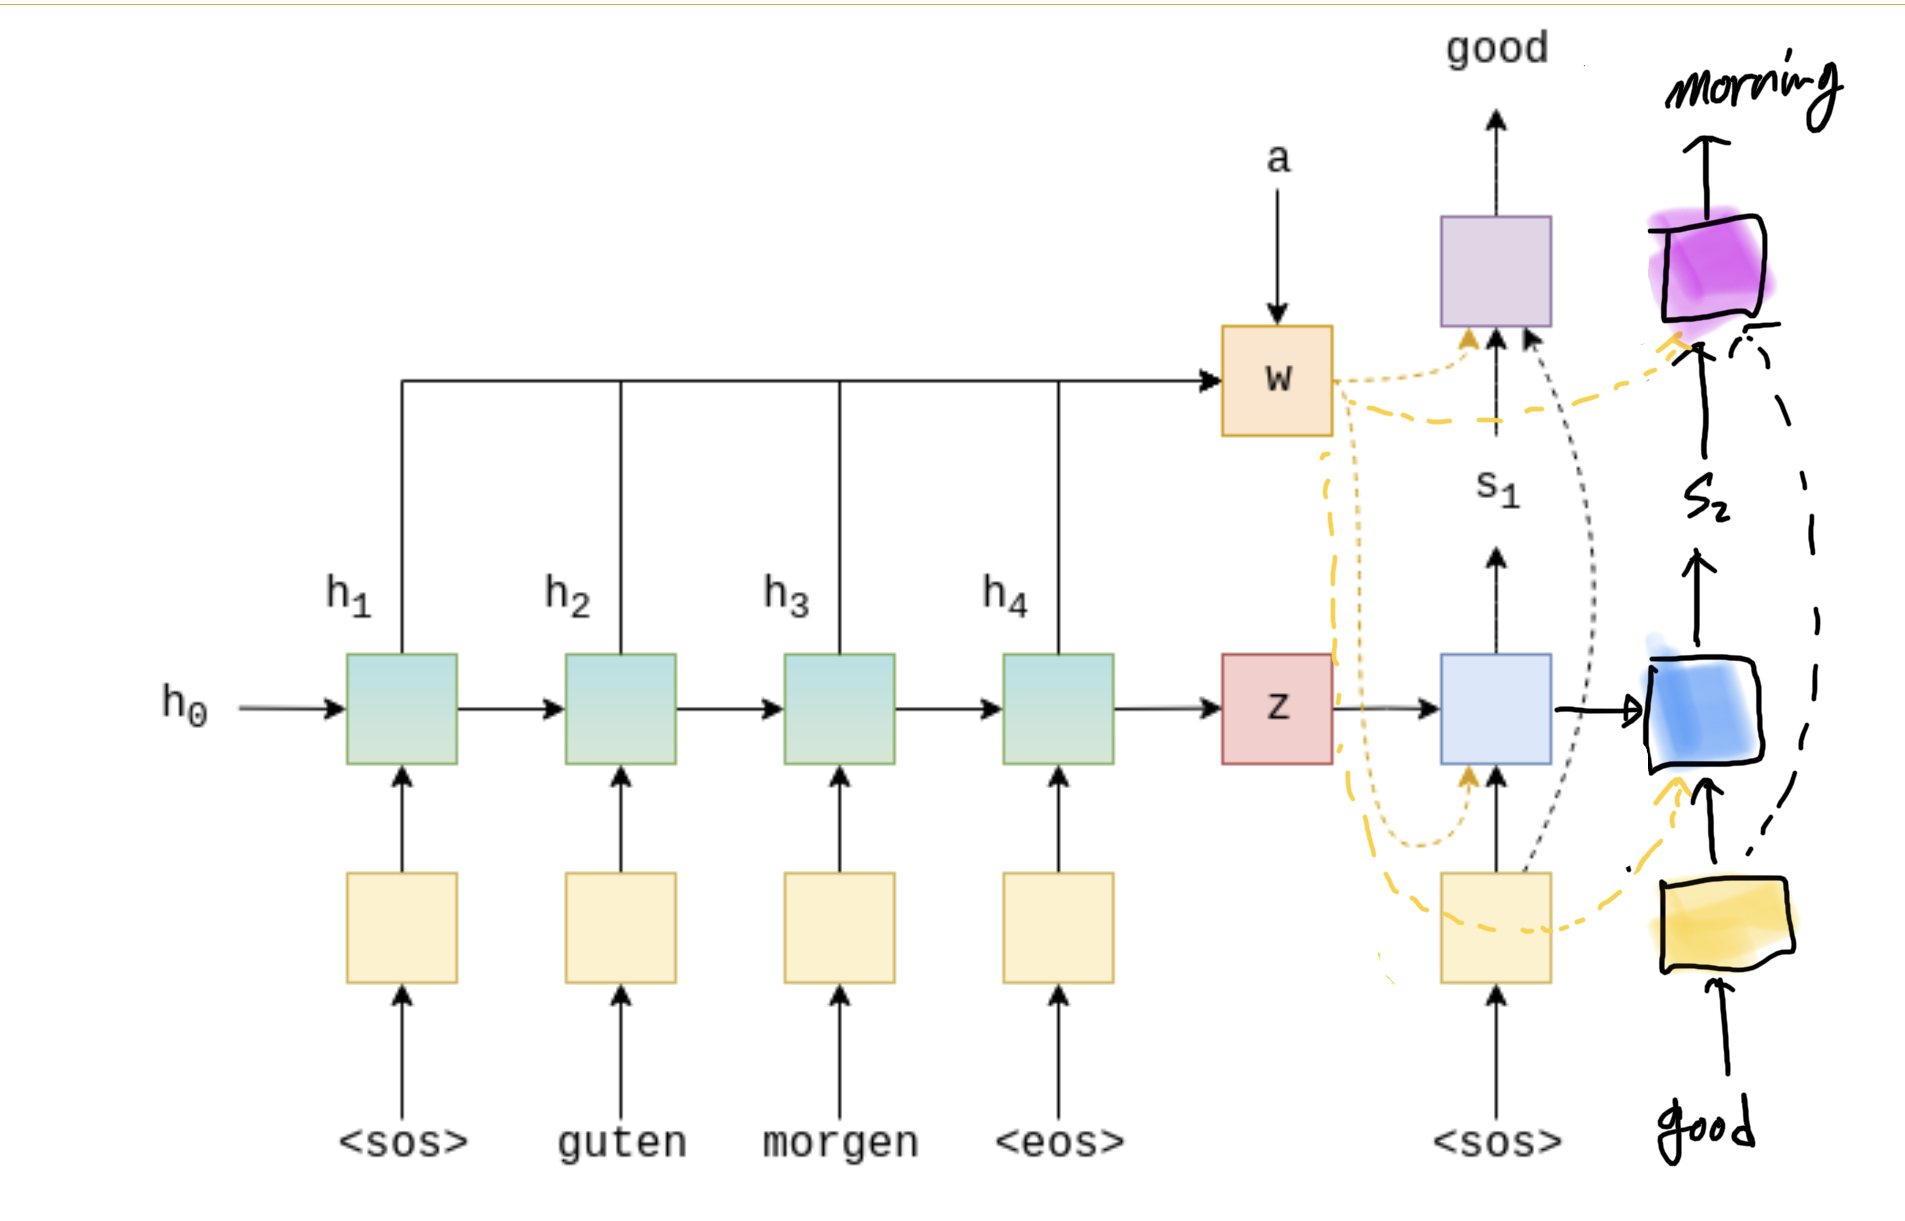
## 3.1 Decoder: General Description

제안된 모델의 디코더는 아래와 같이 조건부 확률을 계산한다.
$p(y_i|y_1,...,y_{i-1},\textbf{x})=g(y_{i-1},s_i,c_i)$
여기서 $y_i$는 i번째 target word, $g()$는 비선형 함수(즉, RNN), $s_i$는 time i에 해당하는 디코더 RNN의 hidden state, $c_i$는 time $i$의 context vector를 의미한다. 제안된 모델과 기존 인코더-디코더 모델의 차이점은 context vector가 한 개가 아니고, time step마다 다른 context vector를 사용한다는 점이다.<br><br>
Context vector $c_i$는 인코더가 입력 시퀀스를 맵핑한 결과물(인코더 RNN의 hidden states)인 annotation $h$의 시퀀스 $(h_1,...,h_{T_x})$를 사용하여 다음과 같이 구해진다.<br><br>
$c_i=\sum_{j=1}^{T_x}\alpha_{ij}h_j$<br><br>
각각의 annotation $h_i$는 입력 시퀀스의 i번째 단어와 그 주변에 집중하면서도 전체 입력 시퀀스의 정보를 가지고 있다.

여기서 annotation $h_j$의 가중치 $\alpha_{ij}$는 다음과 같이 계산된다.<br><br>
$\alpha_{ij}={exp(e_{ij})}/{\sum_{k=1}^{T_x}exp(e_{ik})}, e_{ij}=a(s_{i-1}, h_j)$<br><br>
$\alpha_{ij}$를 $y_i$가 $x_j$와 align될 확률이라고 하면, context vector $c_i$는 확률 $\alpha_{ij}$를 갖는 모든 annotation들의 기댓값이라고 할 수 있다. 확률 $\alpha_{ij}$는 hidden state $s_{i-1}$로 next state $s_i$를 결정하고 $y_i$를 생성할 때 annotation $h_j$가 얼마나 중요한지를 나타내어 디코더가 source 문장의 어느 부분에 집중해야 할지 결정해주는 역할을 한다. 이것을 attention mechanism이라고 하고, 이 메커니즘 덕분에 인코더는 고정된 길이의 벡터에 모든 정보를 담으려고 애쓸 필요가 없다.<br><br>
$a(s_{i-1}, h_j)$는 alignment model이고, 입력 시퀀스의 j번째와 출력 시퀀스의 i번째가 얼마나 잘 부합하는지 평가하는 역할을 한다. 저자는 alignment model a로 Feedforward Neural Network를 사용했으며, a는 시스템의 다른 부분과 같이 jointly trained 된다. <br><br>

요약하면 인코더는 input sequence로부터 annotation h(인코더의 hidden states)를 생성한다. <br>
디코더는 이전 time step의 디코더 RNN hidden state $s_{i-1}$과 인코더의 모든 hidden states(annotations)를 alignment model(attention layer)에 입력해 annotation의 가중치 $\alpha$를 계산한다.<br>
그 다음 디코더 RNN의 이전 hidden state $s_{i-1}$과 annotation에 가중치를 적용하여 얻은 context vector $c_i$, 그리고 이전에 예측한 단어 $y_{i-1}$을 사용하여 단어 $y_i$를 예측한다.

## 3.2 Encoder

인코더는 입력 시퀀스로부터 annotation을 생성하는 역할을 한다. 일반적인 인코더-디코더 모델에서 인코더는 context vector를 생성할 때 첫 번째 단어부터 마지막 단어까지 순서대로 보는데, 제안된 모델에서는 이전의 단어들과 뒤따라오는 단어들까지 보기 위해서 BiRNN을 사용하였다.<br><br>
이 코드에서는 Bidirectional GRU를 사용하였다.
Annotation $h_j$는 BiRNN의 forward hidden state와 backward hidden state를 concatenate해서 계산했다.<br><br>
$h_j=[\overrightarrow{{h_j}^\top};\overleftarrow{{h_j}^\top}]^\top$

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        '''self.embedding에 토큰의 정수 인덱스(vocabulary에서 지정된)가 들어오면 emb_dim차원의 벡터로 임베딩하여 출력한다.
           input_dim은 source 언어 토큰의 가짓수(source vocabulary의 길이)에 해당한다.
           self.embedding은 input_dim 가지의 emb_dim 차원의 임베딩 벡터를 출력할 수 있다.'''
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        '''RNN은 bidirectional GRU를 사용하였다. GRU는 RNN의 일종으로 LSTM의 구조를 단순화해 학습 속도를 높였지만 성능은 유사한 것으로 알려져 있다. 
           Bidirectional GRU 사용을 위해 세 번째 인자인 bidirectional을 True로 설정한다.
           첫 번째 인자는 input_size로 GRU input의 차원을 의미한다. 입력될 토큰을 emb_dim 차원의 벡터로 임베딩했기 때문에 input_size는 emb_dim이다.
           두 번째 인자는 hidden_size이다. hidden_size는 enc_hid_dim으로 설정한다.'''
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        '''인코더는 양방향 RNN이어서 enc_hid_dim*2 차원의 hidden state를 갖지만 디코더는 단방향 RNN이어서 dec_hid_dim 차원의 hidden state를 갖는다.
           따라서 input size가 enc_hid_dim*2, output size가 dec_hid_dim인 nn.Linear 레이어를 사용하여 
           인코더 hidden states의 차원을 디코더 hidden states의 차원에 맞게 조절한다.
           차원을 조절하는 이유는 디코더 RNN hidden state의 초기값이 인코더 RNN의 마지막 hidden state로부터 초기화되기 때문이다.'''
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        '''nn.Dropout은 드롭아웃 레이어이다. 여기서는 임베딩된 토큰 벡터의 특정 엔트리가 dropout만큼의 확률로 0이 되도록 하는 역할을 한다.
           과적합을 억제하는 목적이다.'''
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        '''src 텐서의 값을 출력하려면 주석처리 해제
        print("src")
        print("shape : ", src.shape)
        print(src)'''
        #src = [src len, batch size]
        #src 토큰을 임베딩하고 드롭아웃을 적용한다.

        embedded = self.embedding(src)
        '''임베딩된 텐서의 값을 출력하려면 주석처리 해제
        print("embedded before dropout")
        print("shape : ", embedded.shape)
        print(embedded)'''
        embedded = self.dropout(embedded)
        '''드롭아웃 이후 임베딩 텐서의 값을 출력하려면 주석처리 해제
        print("embedded after dropout")
        print("shape : ", embedded.shape)
        print(embedded)'''
        
        #embedded = [src len, batch size, emb dim]
        #BiGRU에 임베딩된 벡터의 시퀀스를 입력해 output과 마지막 hidden state를 얻는다.
        outputs, hidden = self.rnn(embedded)
        '''outputs 텐서와 hidden 텐서의 크기와 값을 확인하려면 주석처리 해제
        print("outputs")
        print("shape : ", outputs.shape)
        print(outputs)
        print("hidden")
        print("shape : ", hidden.shape)
        print(hidden)'''

        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        '''인코더의 마지막 hidden state를 사용해 디코더의 초기 hidden state를 정하기 위해서 
           fully connected layer를 사용해 dec_hid_dim 차원으로 맵핑한다.'''
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        '''Fully connected 레이어를 통과한 후의 hidden 텐서의 크기와 값을 확인하려면 주석처리 해제
        print("hidden after FC layer")
        print("shape : ", hidden.shape)
        print(hidden)'''
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

## 인코더에서 각 텐서의 크기와 값
### src
shape :  torch.Size([12, 1])<br>
tensor([[ 2],
        [43],
        [54],
        [53],
        [21],
        [ 6],
        [ 0],
        [47],
        [ 6],
        [ 0],
        [ 4],
        [ 3]], device='cuda:0')

src 텐서의 크기와 값을 확인하였다. src 텐서의 크기는 (src_len, batch_size)이다.
하나의 데이터에 대해 값을 확인하기 위해 batch_size는 1로 설정하였다. 따라서 src에 패딩 토큰은 포함되어 있지 않고, src_len은 해당 데이터의 토큰 갯수이다.<br>
src는 벡터의 시퀀스가 아닌 정수(스칼라)의 시퀀스임을 확인하였다. Source vocabulary에서 각 토큰의 인덱스를 가져온 것이기 때문에 정수 시퀀스이다.
<br><br>
### embedded before dropout
shape :  torch.Size([12, 1, 256])<br>
tensor([[[-1.0058e-03,  5.2595e-04,  8.2303e-03,  ...,  9.1974e-03,
           3.9426e-03, -1.4976e-02]],

        [[-1.4218e-02, -2.6302e-03,  6.3305e-04,  ...,  6.8626e-03,
           1.2413e-02,  1.2342e-02]],

        [[ 6.3215e-03,  6.9133e-03,  1.9552e-06,  ..., -1.3609e-02,
          -7.4945e-03,  4.8962e-03]],

        ...,

        [[-3.9967e-04,  2.0791e-02,  1.3522e-02,  ...,  1.1071e-02,
          -7.9668e-03, -3.5627e-03]],

        [[-1.0002e-02,  3.7553e-03,  3.9509e-03,  ..., -1.4424e-02,
           1.9729e-02, -3.0840e-03]],

        [[-1.6539e-03,  4.1173e-03, -1.5598e-03,  ..., -5.6654e-03,
           5.0314e-03, -1.7384e-03]]], device='cuda:0',
       grad_fn=<EmbeddingBackward0>)

드롭아웃을 적용하기 전의 embedded 텐서의 크기와 값을 확인하였다.<br>
embedded 텐서의 크기는 (src_len, batch_size, emb_dim)이다.<br>
batch_size=1, emb_dim=256으로 설정하였고, 입력된 시퀀스의 길이가 12였기 때문에 크기가 (12, 1, 256)이다. <br>
정수 시퀀스인 src가 임베딩 레이어를 통과한 후 256차원의 벡터 시퀀스로 바뀐 것을 확인할 수 있다.<br>

### embedded after dropout
shape :  torch.Size([12, 1, 256])<br>
tensor([[[-2.0115e-03,  1.0519e-03,  1.6461e-02,  ...,  0.0000e+00,
           0.0000e+00, -2.9952e-02]],

        [[-2.8436e-02,  0.0000e+00,  1.2661e-03,  ...,  1.3725e-02,
           0.0000e+00,  0.0000e+00]],

        [[ 1.2643e-02,  1.3827e-02,  3.9105e-06,  ..., -2.7217e-02,
          -1.4989e-02,  9.7923e-03]],

        ...,

        [[-7.9933e-04,  4.1582e-02,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -7.1253e-03]],

        [[ 0.0000e+00,  0.0000e+00,  7.9018e-03,  ...,  0.0000e+00,
           3.9459e-02, -6.1680e-03]],

        [[-3.3078e-03,  8.2345e-03, -3.1195e-03,  ...,  0.0000e+00,
           1.0063e-02, -3.4769e-03]]], device='cuda:0',
       grad_fn=<FusedDropoutBackward0>)<br>

드롭아웃 적용 후의 embedded 텐서의 크기와 값을 확인하였다.<br>
마찬가지로 텐서의 크기는 (src_len, batch_size, emb_dim)이다.<br>
같은 크기의 텐서지만 드롭아웃 적용 전과 후를 비교해 보면, 드롭아웃 적용 후에는 일부 값들이 0으로 대체된 것을 확인할 수 있다. <br><br>

### outputs
outputs<br>
shape :  torch.Size([10, 1, 1024])<br><br>
tensor([[[-0.2559, -0.0889,  0.0823,  ..., -0.0383,  0.3844,  0.1425]],

        [[-0.1357,  0.2881,  0.1166,  ...,  0.0193,  0.3934, -0.1919]],

        [[-0.2893, -0.1006,  0.2713,  ...,  0.3891,  0.3544, -0.0740]],

        ...,

        [[ 0.0018, -0.2681, -0.5705,  ..., -0.0538,  0.0369,  0.2897]],

        [[ 0.2260, -0.0222, -0.3895,  ..., -0.0426, -0.1040,  0.2616]],

        [[ 0.1556, -0.3380, -0.1188,  ..., -0.3660, -0.2379, -0.0368]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward0>)

outputs 텐서의 크기와 값을 확인했다. 크기는 (src_len, batch_size, 2*enc_hid_dim)이다. 확인한 데이터의 길이가 10이고 batch_size=1, enc_hid_dim=512로 설정했기 때문에 (10, 1, 1024) 크기의 텐서이다. <br>
outputs는 시퀀스의 각 time step에서의 인코더 RNN의 hidden state에 해당하는 텐서이다.<br> 
크기의 마지막 값이 2*enc_hid_dim인 이유는 사용된 RNN이 bidirectional GRU이기 때문이다. Bidirectional GRU는 forward hidden state와 backward hidden state를 가지므로 전체 hidden state의 크기는 2*enc_hid_dim이 된다.<br>
outputs의 3번째 차원에서 앞의 512개는 인코더 RNN의 forward hidden state이고, 뒤의 512개는 backward hidden state이다.<br>
논문의 notation으로 표현하면 outputs는 annotation의 시퀀스이다.

### hidden
shape :  torch.Size([2, 1, 512])<br>
tensor([[[ 0.1556, -0.3380, -0.1188,  ...,  0.1123, -0.0881, -0.1072]],

        [[ 0.1462,  0.1434, -0.4461,  ..., -0.0383,  0.3844,  0.1425]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward0>)
hidden 텐서의 크기와 값을 확인했다.<br>
hidden 텐서는 인코더 RNN의 마지막 time step에서의 hidden state이다.
hidden 텐서의 크기는 (2, batch_size, enc_hid_dim)이다. 크기의 맨 앞 값이 2인 이유는 bidirectional GRU이기 때문이고, bidirectional=False인 경우에는 크기의 맨 앞 값은 1이 된다.<br>
hidden 텐서의 첫 번째 차원의 인덱스 0에는 forward hidden state가, 인덱스 1에는 backward hidden state가 저장되어 있다.<br>

### hidden after FC layer
shape :  torch.Size([1, 512])<br>
tensor([[ 1.1117e-01,  3.2016e-01,  5.0236e-02, -1.7864e-01,  1.9376e-01,
         -3.7601e-02, -8.6925e-02, -2.5820e-01,  1.8682e-01, -2.8013e-01,
         ...,
          7.3503e-02,  1.6862e-01, -1.4567e-01,  5.4925e-02, -1.1120e-01,
         -7.0257e-02,  1.4193e-01, -1.9306e-01,  6.6286e-04,  9.6617e-02,
         -6.1719e-03, -1.0431e-01, -1.0917e-01, -7.2579e-02,  2.6661e-01,
          4.4102e-02,  1.4355e-01]], device='cuda:0', grad_fn=<TanhBackward0>)

Fully connected layer를 통과한 후의 hidden 텐서의 크기와 값을 확인하였다.<br>
디코더 RNN은 Unidirectional GRU로 forward hidden state만을 갖는데, 디코더 RNN의 hidden state의 초기값이 인코더 RNN의 마지막 hidden state로 정해지기 때문에 둘 사이에 차원을 동일하게 해주기 위해서 fully connected layer를 사용하였다.<br>
Fully connected layer를 통과한 후의 크기는 (batch_size, dec_hid_dim)이다.<br>
batch_size=1, dec_hid_dim=512이므로 크기가 (1,512)이다. 

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        '''output_dim은 인코더의 input_dim과 마찬가지로 타겟 언어의 토큰 종류 수를 의미한다.
           (target vocabulary의 길이)'''
        self.output_dim = output_dim
        self.attention = attention

        '''인코더에서와 마찬가지이다.
           emb_dim만큼 길이의 임베딩 벡터를 output_dim만큼의 종류로 생성한다.
           self.embedding에 토큰의 index(정수)가 주어지면 emb_dim 차원의 벡터를 출력한다.''' 
        self.embedding = nn.Embedding(output_dim, emb_dim)

        '''RNN은 GRU를 사용하였다. 인코더와 달리 bidirectional=False이다. (default)'''
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        '''인코더와 마찬가지로 과적합 방지를 위해 드롭아웃을 사용한다.'''
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        '''input은 디코더가 이전 time step에서 예측한 단어인 y_i-1 에 해당한다.
           임베딩된 벡터를 RNN에 집어넣으려면 (1, batch size, emb dim)의 차원으로 만들어야 하기 때문에
           임베딩 이전에 unsqueeze 함수를 사용해 차원을 아래 주석처럼 변경한다.'''
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        '''input의 크기와 값을 확인하려면 아래 주석처리 해제
        print("input")
        print("shape : ", input.shape)
        print(input)'''

        '''임베딩하고 드롭아웃을 적용한다.'''
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        '''embedded의 크기와 값을 확인하려면 아래 주석처리 해제
        print("embedded")
        print("shape : ", embedded.shape)
        print(embedded)'''
        
        '''여기서 hidden은 디코더의 이전 time step에서의 hidden state에 해당한다.
           encoder_outputs는 인코더 클래스의 output(모든 time step에서의 hidden states)에 해당한다.
           hidden과 encoder_outputs, 어텐션 레이어를 사용해 a를 계산하는데 여기서 a는 논문에서의 alpha_ij에 해당한다.'''
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        '''a의 크기와 값을 확인하려면 아래 주석처리 해제
        print("a")
        print("shape : ", a.shape)
        print(a)'''
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        '''torch.bmm은 batch의 각 요소에 대해서 행렬곱을 수행하는 함수이다. 
           각 데이터의 a(annotation의 가중치)와 encoder_outputs(annotations)를 곱하는 연산이다.
           결과인 weighted는 논문에서 context vector c_i에 해당한다.'''
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        '''weighted의 크기와 값을 확인하려면 아래 주석처리 해제
        print("weighted")
        print("shape : ", weighted.shape)
        print(weighted)'''
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        '''rnn_input은 embedded(y_i-1)와 weighted(c_i)를 concatenate한 것이다.'''
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        '''hidden은 디코더 RNN의 이전 hidden state에 해당하고 rnn_input은 y_i-1과 c_i에 해당한다.
           이전 hidden state와 이전에 예측한 단어, context vector를 사용하여 현재 디코더 RNN hidden state s_i를 계산하는 연산이다.
           한 단어씩 예측하고 있으므로 예측하는 시퀀스의 길이인 sequence length는 1이고, 따라서 output과 hidden은 같은 값이다.'''
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        '''output과 hidden의 크기와 값을 확인하려면 아래 주석처리 해제
        print("output")
        print("shape : ", output.shape)
        print(output)
        print("hidden")
        print("shape : ", hidden.shape)
        print(hidden)'''
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        '''output(현재 디코더 RNN hidden state, s_i)과 weighted(c_i), embedded(y_i-1)을 사용해 현재 단어 y_i를 예측하기 위해 prediction을 계산한다.
           output, weighted, embedded를 concatenate해서 fc_out에 입력하여 얻은 prediction의 차원은 output_dim(target vocabulary length)이다.
           즉, prediction은 target vocabulary에서 각 토큰이 적합한 토큰일 확률을 담고 있는 벡터이고, 논문에서의 조건부확률p(y_i|y_1,...,y_i-1,x)에 해당한다.'''
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        '''prediction의 크기와 값을 확인하려면 아래 주석처리 해제
        print("prediction")
        print("shape : ", prediction.shape)
        print(prediction)'''
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

## 디코더에서 각 텐서의 크기와 값

### input
shape :  torch.Size([1, 1])<br>
tensor([[493]], device='cuda:0')<br><br>

input의 크기와 값을 확인하였다.<br>
input은 vocabulary에서 가져온 토큰의 인덱스이므로 정수이다. 그리고 디코더에서 출력을 예측할 때 이전 단어로부터 다음 단어를 예측하기 때문에, 인코더에서와 달리 input은 정수 시퀀스가 아닌 하나의 정수이다.<br>
input의 크기는 (1, batch_size)인데, 편의를 위해 batch_size=1로 설정했기 때문에 출력된 크기는 (1,1)이다. 

### embedded
shape :  torch.Size([1, 1, 256])<br>
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  1.0278, -2.1916,  0.0000,
           1.0294,  0.2306,  0.0000, -2.5073, -1.7833,  0.0000,  0.0000,
           0.0000,  0.0000,  0.6073,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.9931, -1.5143,  0.0000,  0.0000,  0.0000,  0.6433,
           0.0000, -1.8455, -2.1008,  0.0000,  0.0000, -0.1375,  0.0000,
           0.0000,  0.6698,  1.7002,  1.6403,  0.0000,  0.0000, -0.3032,
           1.2269,  0.0000,  0.0000,  2.2168, -3.0543,  0.0000,  0.0000,
           0.0000, -1.5961,  0.0000,  0.0000,  0.5625, -0.9799,  0.0000,
          -1.1852,  0.0000, -1.6573,  0.3837,  0.0000,  0.0000, -0.8223,
          -2.7916,  0.0000, -1.4180,  1.1416, -0.8009,  0.0000, -1.0494,
           0.0000,  0.0000,  2.0057,  0.0000,  0.0000,  2.8182, -0.0432,
           0.0000,  0.0000,  0.0000,  0.0000, -0.6618, -1.0902,  0.0000,
           0.0000,  0.2917, -1.4150,  0.0000,  0.0000,  1.9240,  0.0000,
           0.6875,  0.3210,  1.7475,  2.2313, -3.9490, -0.7699,  0.0000,
          -1.5663,  0.0000,  1.2638, -0.9939,  0.3149,  0.0000,  0.0000,
           1.7085,  0.0000,  2.6002,  0.0000, -2.5947,  0.0000,  0.0000,
          -1.4400,  0.0000,  0.0000,  3.6958, -0.8666,  0.0000,  0.0000,
           0.0000,  0.1127, -2.3348, -1.0919,  0.0000, -1.4292,  0.9237,
           0.8809,  0.0000, -1.6149,  1.0492, -2.4419,  4.7859,  0.0000,
          -1.4914,  1.5038, -1.4563, -2.1475,  4.6503, -0.3654,  0.0000,
           1.6993, -0.9220,  3.1818,  0.0000,  2.2347,  2.2196,  0.0000,
          -4.3486,  2.9787,  0.0000,  0.0000,  0.0000, -1.2258,  0.0000,
           0.0000,  3.4740, -2.1464, -2.7758, -0.2509,  0.0000,  0.0000,
          -1.6299, -1.6022,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.8532, -4.9648, -0.4772,  0.0000,  1.5033,  0.0000,
           0.0487,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2402,
           0.1740,  0.0000,  0.0000,  0.1351, -4.6724, -2.8415,  0.0000,
           1.2289,  2.9565, -0.5945,  0.0000, -0.6577,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.3566, -1.6565, -0.7264,  2.5501,
           1.4161, -3.3074,  0.6935,  0.0000,  0.1336,  0.0000,  0.0000,
           0.0000,  1.7450,  0.0000,  0.2064,  0.0000,  0.0000, -0.3638,
          -1.8868, -1.1422,  0.0000,  0.0000,  0.5598,  3.1360,  0.0000,
           0.0000,  2.8569,  0.5179, -2.5293,  0.0000,  0.0000,  0.8168,
           0.0000, -0.2955,  0.0000,  0.0000,  3.3257, -1.1703,  1.1961,
           0.0000,  0.0000,  0.7634,  0.0000, -1.8957,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, -3.0715,  1.7371,  0.6131,
           0.0000,  1.0535,  0.4476, -0.7270]]], device='cuda:0',
       grad_fn=<FusedDropoutBackward0>)<br><br>

embedded의 크기와 값을 확인하였다.<br>
embedded는 input이 임베딩 레이어를 통과한 결과이다. 256차원의 벡터가 출력된 것을 확인하였다.<br>
하나의 정수인 input은 emb_dim 차원의 벡터로 임베딩되고, 따라서 embedded의 크기는 (1, batch_size, emb_dim)이다. <br>
embedded의 크기를 이와 같이 만든 이유는 RNN의 입력으로 사용하기 위해서는 텐서를 (sequence length, batch size, input size) 형태로 만들어야 하기 때문이다.<br>
디코더 RNN은 이전 단어로 현재 단어를 예측하므로 한 번에 하나의 단어만 입력되어 sequence length는 1이고, batch size는 편의상 1로 설정하였다.<br>
### a
shape :  torch.Size([1, 1, 17])<br>
tensor([[[0.0603, 0.0591, 0.0566, 0.0505, 0.0600, 0.0640, 0.0573, 0.0552,
          0.0543, 0.0528, 0.0583, 0.0610, 0.0639, 0.0654, 0.0556, 0.0622,
          0.0634]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>) <br><br>

a의 크기와 값을 확인하였다.<br>
a는 어텐션 레이어에서 계산된 $\alpha_{ij}$에 해당한다.<br>
어텐션 레이어에서 현재 디코더의 time step $i$와, source sentence의 모든 time step $j$에 대해 $\alpha_{ij}$를 계산하였기 때문에, a의 크기는 (batch_size, 1, src_len)이 된다.<br>
원래 (batch_size, src_len)의 크기로 주어진 a를 unsqueeze()함수를 사용해 위와 같이 크기를 바꿨는데, 인코더의 hidden state와 행렬곱을 하기 위해 차원을 변경한 것이다. <br><br>

### weighted
shape :  torch.Size([1, 1, 1024])<br>
tensor([[[-0.2273,  0.0452, -0.0101,  ...,  0.0573, -0.1044,  0.0655]]],
       device='cuda:0', grad_fn=<BmmBackward0>) <br>

weighted의 크기와 값을 확인하였다.<br>
weighted는 어텐션 레이어에서 계산한 가중치 a($\alpha_{ij}$에 해당)와 인코더의 모든 hidden state(annotation $h_j$의 시퀀스에 해당)인 encoder_outputs를 곱한 값이다.<br>
논문에서의 context vector $c_i$에 해당한다.<br>
$c_i$는 annotation의 기댓값이므로 인코더의 hidden state와 크기가 같다. 따라서 weighted의 크기는 (1, batch_size, 2*enc_hid_dim)이다.<br>
weighted는 디코더가 이전에 예측한 단어인 embedded와 concatenate되어 디코더 RNN의 입력으로 사용된다.

### output
shape :  torch.Size([1, 1, 512])<br>
tensor([[[ 5.1070e-02, -4.0473e-01,  2.4675e-02, -7.6167e-02, -3.6387e-01,
           3.4587e-01,  7.0745e-02,  1.3340e-01,  5.8603e-01, -2.0509e-01,
          -5.5327e-02,  4.1421e-02,  9.1851e-02,  6.2232e-02,  3.4722e-01,
          -2.9451e-01,  3.4979e-01,  3.0131e-02, -3.4268e-01,  1.5122e-01,
           2.2833e-01, -4.1962e-01,  3.1972e-01, -3.9625e-01,  8.8956e-02,
           ...,
          -2.2622e-01, -2.9360e-01,  3.2328e-01,  4.0752e-01, -3.8703e-01,
          -3.9909e-04, -2.5616e-01, -2.0405e-01, -1.8657e-01, -2.5872e-01,
           2.2508e-01, -6.6083e-02, -3.9613e-01, -2.8467e-01,  1.1525e-01,
           2.9149e-01, -2.5250e-01, -4.5006e-01,  2.8592e-01,  3.3588e-02,
          -1.9821e-01, -1.9332e-01,  1.3067e-01, -1.6874e-01, -1.1018e-01,
          -2.0579e-01,  1.5835e-01,  5.2573e-01, -2.3983e-01, -2.2157e-01,
          -2.6734e-01,  3.4315e-01,  1.2792e-03, -7.1170e-02, -2.1509e-01,
          -6.7657e-02,  2.9492e-01, -2.4463e-01, -9.5405e-02,  8.6931e-02,
           4.0432e-01, -5.3438e-01,  2.2115e-01, -2.2290e-01, -1.0873e-01,
          -1.4330e-01, -4.6699e-01,  4.8212e-01,  2.3882e-02,  5.7066e-03,
           4.1600e-01,  1.3583e-01]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>) <br>

output의 크기와 값을 확인하였다.<br>
output은 디코더 RNN의 현재 hidden state $s_i$에 해당하는 값이다.<br>
따라서 크기는 (1, batch_size, dec_hid_dim)이다. 크기의 맨 처음 값이 1인 이유는 디코더에 단어가 하나씩 입력되므로 sequence length가 1이기 때문이다.

### hidden
shape :  torch.Size([1, 1, 512]) <br>
tensor([[[ 5.1070e-02, -4.0473e-01,  2.4675e-02, -7.6167e-02, -3.6387e-01,
           3.4587e-01,  7.0745e-02,  1.3340e-01,  5.8603e-01, -2.0509e-01,
          -5.5327e-02,  4.1421e-02,  9.1851e-02,  6.2232e-02,  3.4722e-01,
          -2.9451e-01,  3.4979e-01,  3.0131e-02, -3.4268e-01,  1.5122e-01,
          ...,
          -3.1784e-01, -6.8284e-01, -3.0646e-01,  5.8646e-02, -4.0654e-02,
          -5.5964e-02, -6.9471e-02, -1.1139e-01,  2.5759e-01,  1.3446e-01,
          -1.3398e-01,  2.9779e-02, -1.3397e-01,  1.7963e-01, -1.8601e-01,
           4.0432e-01, -5.3438e-01,  2.2115e-01, -2.2290e-01, -1.0873e-01,
          -1.4330e-01, -4.6699e-01,  4.8212e-01,  2.3882e-02,  5.7066e-03,
           4.1600e-01,  1.3583e-01]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>) <br>

디코더에 하나의 단어(이전에 예측한 단어)가 입력되므로 sequence length가 1이고, 따라서 디코더의 마지막 hidden state인 hidden은 위의 output과 동일하다.<br>
따라서 output과 크기도 같고, 값도 동일하다.

### prediction
shape :  torch.Size([1, 5893]) <br>
tensor([[ 0.4798,  0.0345, -0.1961,  ..., -0.2905, -0.0102,  0.0109]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

prediction은 디코더의 hidden state($s_i$) output과 context vector $c_i$인 weighted, 디코더가 이전에 예측한 단어 $y_{i-1}$인 embedded를 concatenate해서 fully connected layer에 입력해 얻은 값이다.<br>
아래와 같은 조건부 확률을 계산한 결과에 해당한다.<br> 
$p(y_i|y_1,...,y_{i-1},\textbf{x})=g(y_{i-1},s_i,c_i)$<br>
Fully connected layer의 출력 차원은 target vocabulary의 크기(target vocabulary에 포함된 토큰의 수)에 해당한다.

In [15]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        '''self.attn과 self.v는는 논문에서 alignment model a(s_i-1, h_j)에 해당하는 fully connected layer이다.
           annotation h_j와 디코더의 이전 hidden state s_i-1을 사용하여 annotation의 가중치 alpha를 계산하는 역할이다.'''
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        '''(논문의 notation을 따름)
           모든 k에 대해 energy e_ik를 계산하고 결과적으로 alpha_ij를 구하기 위해
           디코더의 이전 time step의 hidden state, s_i-1, 에 해당하는 hidden을 
           src_len(입력 시퀀스의 길이, 논문에서의 T_x)만큼 복제한다.'''
        
        '''hidden의 크기를 확인하려면 아래 주석처리 해제
        print("hidden : ", hidden.shape)'''
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        '''encoder_outputs는 인코더의 모든 time step에서의 hidden states이다.'''
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        '''encoder_outputs의 크기를 확인하려면 아래 주석처리 해제
        print("encoder_outputs : ", encoder_outputs.shape)'''
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        '''hidden(s_i-1)과 encoder_outputs(h_1,...,h_T_x)를 concatenate하여 self.attn, self.v에 차례로 입력해 energy e_ij를 계산한다.
           fully connected layer인 self.attn과 self.v 사이의 활성화함수는 tanh가 사용되었다.
           고정된 i와 모든 j(1,...,T_x)에 대해 alpha를 계산한다.'''

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        '''energy의 크기와 값을 확인하려면 아래 주석처리 해제
        print("energy")
        print("shape : ", energy.shape)
        print(energy)'''
        
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        '''attention의 크기와 값을 확인하려면 아래 주석처리 해제
        print("attention")
        print("shape : ", attention.shape)
        print(attention)'''

        attention = F.softmax(attention, dim=1)
        '''softmax 이후 attention의 크기와 값을 확인하려면 아래 주석처리 해제
        print("attention")
        print("shape : ", attention.shape)
        print(attention)'''
        
        #attention= [batch size, src len]
        '''energy e_ij에 softmax를 취해 alpha_ij로 만들어 반환한다.
           고정된 i와 모든 j(1,...,T_x)에 대해 alpha_ij가 계산되어 반환된다.'''
        return attention

## Attention 클래스에서 각 텐서의 크기와 값

### hidden
hidden :  torch.Size([1, 512])<br> 
hidden은 디코더의 이전 time step의 hidden state $s_{i-1}$에 해당한다.<br>
값은 디코더에서 확인하였기 때문에 크기만 확인하였다.<br>
encoder_outputs와 함께 fully connected layer에 입력되어 energy, attention을 계산하는데 사용된다.<br><br>
$\alpha_{ij}={exp(e_{ij})}/{\sum_{k=1}^{T_x}exp(e_{ik})}, e_{ij}=a(s_{i-1}, h_j)$이고 분모를 계산하기 위해서는 input sequence의 모든 time step에서의 hidden state와 디코더의 이전 hidden state에 대해 연산이 필요함을 알 수 있다.<br><br>
병렬적으로 계산하기 위해 hidden을 input sequence length만큼 복제하고 인코더의 모든 time step의 hidden state인 encoder_outputs와 concatenate하여 한 번에 fully connected layer에 입력되는 것을 코드에서 확인할 수 있다.<br>
또, fully connected layer에 입력되려면 batch size가 텐서 크기의 첫 번째 차원이 되어야 하므로 permute 함수가 사용되었다.<br>
이렇게 repeat 함수와 permute 함수가 적용되고 나면 hidden의 크기는 아래와 같이 변한다.<br>
torch.Size([1, 20, 512])


### encoder_outputs
encoder_outputs :  torch.Size([1, 20, 1024]) <br>
encoder_outputs는 인코더 RNN의 모든 time step에서의 hidden state(annotation의 시퀀스)에 해당한다.<br>
인코더 클래스의 outputs에 해당하고, 마찬가지로 값은 인코더 클래스에서 확인했기 때문에 크기만 확인하였다.<br>
hidden과 마찬가지로 fully connected layer에 입력되어야 하므로 batch size가 텐서의 첫 번째 차원이 되도록 permute 함수를 사용해 수정되었다.<br>
encoder 클래스의 outputs와 크기를 비교해보면 알 수 있다.<br><br>

### energy, attention의 크기와 값은 hidden, encoder_outputs와 다른 데이터로 확인하여 input sequence length가 다름.

### energy
shape :  torch.Size([1, 11, 512])<br>
tensor([[[-7.7650e-02, -7.3061e-06, -7.7176e-02,  ...,  1.9701e-01,
           9.8334e-03,  2.0467e-01],
         [ 1.0646e-01,  5.6690e-02, -1.3624e-01,  ...,  1.6274e-01,
          -7.8837e-02,  2.0809e-01],
         [ 4.2273e-02,  2.4400e-01, -2.0695e-01,  ..., -1.0549e-01,
           7.1047e-02, -8.8972e-02],
         ...,
         [-9.5785e-03, -4.7416e-02,  9.9112e-02,  ...,  2.0672e-01,
          -1.3523e-01,  4.6240e-02],
         [-1.8347e-01,  1.4507e-03,  6.9254e-03,  ...,  2.9650e-02,
          -1.1803e-01,  2.0337e-02],
         [-5.8472e-02,  1.4870e-01, -9.7312e-02,  ...,  2.0529e-01,
          -6.8486e-02, -1.6317e-01]]], device='cuda:0',
       grad_fn=<TanhBackward0>)<br>

energy의 크기와 값을 확인하였다.<br>
논문에서의 energy는 $e_{ij}=a(s_{i-1}, h_j)$로 구해지는 스칼라이지만, 코드에서의 energy는 512차원의 벡터이다. 코드에서는 $e_{ij}$를 구하는 과정과 softmax를 취해 $\alpha_{ij}$를 구하는 과정을 따로 수행하지 않았고, self.attn과 self.v라는 두 개의 fully connected layer를 통과시키는 것으로 구현했다.<br>
따라서 논문에서의 energy와는 크기가 일치하지 않는다.<br><br>

### attention
shape :  torch.Size([1, 11])<br>
tensor([[ 0.0863,  0.0298, -0.0402,  0.0391,  0.0356, -0.0545,  0.0689, -0.1209,
         -0.0307,  0.1268,  0.1863]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)<br>

사실 코드에서의 attention 텐서가 논문에서의 energy에 가깝다. energy 텐서를 self.v fully connected layer에 입력해 (batch_size, input sequence length) 크기의 텐서로 만든 결과이다.<br>
고정된 i와 모든 input sequence time step j에 대해 energy를 계산하였으므로 크기가 (1,11)이다.<br><br>

### Softmax 이후 attention
shape :  torch.Size([1, 11])
tensor([[0.0959, 0.0906, 0.0845, 0.0914, 0.0911, 0.0833, 0.0942, 0.0779, 0.0853,
         0.0998, 0.1059]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

위에서 구한 attention 텐서에 softmax를 취해 $\alpha_{ij}$를 구한 결과이다.<br>
가중치 $\alpha_{ij}$는 스칼라이지만, 모든 input sequnce time step j에 대해 계산했기 때문에 j개가 존재하여 attention 텐서의 크기는 (batch_size, input sequence length)이다.

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        '''src는 소스 문장, trg는 타겟 문장에 해당한다 (문장은 토큰의 정수 인덱스의 시퀀스로 표현됨).
           teacher_forcing_ratio는 teacher forcing을 사용할 빈도이다.
           teacher_forcing이 무엇인지는 아래에서 설명한다.'''
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        '''trg_len은 출력 시퀀스의 길이에 해당한다.'''
        trg_len = trg.shape[0]
        '''trg_vocab_size는 target 언어의 토큰 종류 수를 의미한다.'''
        trg_vocab_size = self.decoder.output_dim
        
        '''디코더의 출력(즉, 예측된 토큰의 확률분포의 시퀀스스)을 저장하기 위해 (문장 길이, 배치크기, 타겟 토큰 종류 수) 크기의 텐서를 생성한다.'''
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        '''encoder_outputs는 인코더의 모든 time step에서의 hidden states, hidden은 인코더의 마지막 hidden state를 의미한다.'''
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        
        '''디코더에 처음 입력되는 토큰은 시퀀스의 시작을 의미하는 '<sos>'으로 하기 위해 input을 trg[0,:]으로 지정한다.'''
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        '''아래 과정을 타겟 문장의 길이(trg_len)만큼 반복한다.'''
        for t in range(1, trg_len):
            
            '''디코더에 input(이전에 예측한 단어, y_i-1, 또는 t=1인 경우 <sos>), 
               hidden(디코더의 이전 hiddenstate, 또는 t=1인 경우 인코더의 마지막 hidden state),
               encoder_outputs(인코더의 모든 timestep에서의 hiddenstates)를 입력하여 
               디코더의 현재 hidden state s_i(output, hidden)를 얻는다.'''
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            '''디코더의 현재 hidden state s_t를 outputs[t]에 저장한다.'''
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            '''random.random()은 0과 1 사이의 실수를 uniform distribution에서 샘플링하는 함수이다.
               즉, random.random()은 teacher_forcing_ratio의 확률로 teacher_forcing_ratio보다 작다.
               teacher_force에 teacher force를 시행할지 여부를 boolean으로 저장한다.'''
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            '''디코더의 현재 hidden state s_t에 해당하는 output은 target vocabulary의 각 token이 적합한 token일 확률을 담고 있다.
               가장 확률이 높은 토큰의 인덱스를 top1에 저장한다.'''
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            '''만일 teacher_force가 true이면 input에 디코더가 이전 timestep에서 예측한 토큰 대신 실제 타겟 토큰인 trg[t]를 사용한다.
               학습 초기에 모델의 성능이 좋지 않을 때, 디코더가 이전에 예측한 단어를 기반으로 현재 단어를 예측하는 것은 무의미한 일일 경우가 많다.
               따라서 학습 속도가 저하될 수 있는데, teacher forcing 기법을 사용하여 일정 확률로 디코더가 예측한 토큰 대신 실제 토큰을 사용하여 다음 토큰을
               예측하도록 함으로써 학습 속도를 높일 수 있다.'''
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        '''반환되는 outputs는 모든 target time step i에 대해 디코더가 예측한 확률분포의 시퀀스이다.'''

        return outputs

## 모델 생성

임베딩 벡터 차원, hidden state 차원, dropout probability 등 다양한 하이퍼파라미터를 정의한다. 하이퍼파라미터는 논문과는 다르게 정해졌다.<br><br>
앞에서 정의한 클래스를 사용해 모델을 정의하고 GPU(사용가능한 경우)에 전송한다.

In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

모델의 파라미터를 초기화한다. <br>
모든 bias는 0으로, weight는 $\mathcal{N}(0, 0.01)$을 따르도록 초기화한다.

In [18]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

모델의 학슴 가능한 파라미터의 갯수를 확인한다.

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


옵티마이저는 Adam을 사용한다. learning rate와 beta, eps는 기본값을 사용한다.

In [20]:
optimizer = optim.Adam(model.parameters())

손실함수는 cross entropy loss를 사용한다.<br>
디코더가 현재 단어 $y_i$를 예측할 때 target vocabulary의 각 토큰들이 $y_i$가 될 확률을 예측하는데, 이 과정이 multiclass classification 문제와 비슷하기 때문에 cross entropy loss를 사용하여 학습시킬 수 있다.<br>
패딩 토큰은  미니배치의 문장들이 같은 길이를 갖도록 길이가 짧은 문장에 추가된 것이므로 의미있는 정보를 가지고 있지 않기 때문에 패딩 토큰은 loss 계산에서 제외하도록 설정한다.


In [21]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

모델 학습을 위한 함수를 정의한다.<br>

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    
    '''오차역전파를 위한 gradient가 계산되도록 model.train()을 사용한다.'''
    model.train()
    
    epoch_loss = 0
    '''각 미니배치에 대해 아래 코드를 실행한다.'''
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg
        '''옵티마이저의 gradient를 0으로 초기화한다.'''
        optimizer.zero_grad()
        '''output은 모델이 예측한 y_i에 대한 확률분포의 시퀀스이다.'''
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        '''output의 shape는 (batch의 총 토큰 수, target vocabulary의 토큰 수) 이다.'''
        output = output[1:].view(-1, output_dim)
        '''trg의 shape는 (batch의 총 토큰 수)이다. trg는 확률분포가 아닌 정수 인덱스의 시퀀스이기 때문에 크기가 1차원이다.'''
        trg = trg[1:].view(-1)
        '''output, trg의 크기와 값을 확인하려면 아래 주석처리 해제
        print(output.shape)
        print(output)
        print(trg.shape)
        print(trg)'''
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        '''cross entropy loss를 계산'''
        loss = criterion(output, trg)
        '''loss.backward()로 gradient 계산'''
        loss.backward()
        '''안정적인 학습을 위해 gradient clipping 수행'''
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        '''오차역전파 수행'''
        optimizer.step()
        '''해당 epoch의 총 loss를 확인하기 위해 loss를 더함'''
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### output의 크기
torch.Size([2320, 5893])<br>
### output의 값
tensor([[  8.9627, -11.4837, -10.9076,  ...,  -4.6737,  -6.0479,  -6.2845],
        [  9.1975,  -7.9801,  -7.6837,  ...,   0.0983,  -0.6287,  -5.5458],
        [  8.5414,  -9.8547, -10.1097,  ...,  -6.1803,  -4.6884,  -5.0877],
        ...,
        [  6.8573, -10.4075, -10.2213,  ...,  -0.3131,  -5.9658,  -8.7993],
        [  3.6745, -10.3402, -10.6992,  ...,  -8.0249,  -6.7191,  -6.9963],
        [  7.0979, -11.9719, -11.9022,  ...,  -4.6471,  -1.9657, -10.0943]],
       device='cuda:0', grad_fn=<ViewBackward0>)<br>
### trg의 크기
torch.Size([2320])<br>
### trg의 값
tensor([ 4,  7, 74,  ...,  1,  1,  1], device='cuda:0')<br>

검증을 위한 함수 정의

In [23]:
def evaluate(model, iterator, criterion):
    '''gradient를 계산할 필요 없으므로 model.eval()로 설정'''
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''아래 코드는 train() 함수와 동일하나 gradient 계산과 오차 역전파를 위한 코드가 제외되었다.'''
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

1 epoch를 학습하는데 필요한 시간을 측정하는 함수 정의의

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

학습할 epoch인 N_EPOCHS를 정의하고 gradient clipping을 위한 하이퍼파라미터 지정.<br>
학습과 검증을 N_EPOCHS만큼 수행하며 학습 loss와 검증 loss를 매 epoch 출력한다.

In [25]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    '''모델을 학습시키는 과정'''
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    '''모델을 검증하는 과정'''
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    '''validation loss가 가장 작은 모델을 저장하는 코드
       (Best model을 저장)'''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 31s
	Train Loss: 5.020 | Train PPL: 151.385
	 Val. Loss: 4.813 |  Val. PPL: 123.080
Epoch: 02 | Time: 1m 29s
	Train Loss: 4.127 | Train PPL:  62.003
	 Val. Loss: 4.586 |  Val. PPL:  98.057
Epoch: 03 | Time: 1m 28s
	Train Loss: 3.471 | Train PPL:  32.180
	 Val. Loss: 3.757 |  Val. PPL:  42.839
Epoch: 04 | Time: 1m 28s
	Train Loss: 2.915 | Train PPL:  18.457
	 Val. Loss: 3.417 |  Val. PPL:  30.479
Epoch: 05 | Time: 1m 28s
	Train Loss: 2.524 | Train PPL:  12.475
	 Val. Loss: 3.293 |  Val. PPL:  26.920
Epoch: 06 | Time: 1m 29s
	Train Loss: 2.237 | Train PPL:   9.369
	 Val. Loss: 3.273 |  Val. PPL:  26.382
Epoch: 07 | Time: 1m 30s
	Train Loss: 1.992 | Train PPL:   7.330
	 Val. Loss: 3.140 |  Val. PPL:  23.111
Epoch: 08 | Time: 1m 28s
	Train Loss: 1.777 | Train PPL:   5.910
	 Val. Loss: 3.223 |  Val. PPL:  25.109
Epoch: 09 | Time: 1m 28s
	Train Loss: 1.607 | Train PPL:   4.986
	 Val. Loss: 3.243 |  Val. PPL:  25.600
Epoch: 10 | Time: 1m 27s
	Train Loss: 1.496 | Train PPL

검증 데이터에 대해 가장 높은 성능을 보인 모델을 불러온다.<br>
불러온 모델을 사용해 테스트 데이터에 대해 loss와 perplexity를 계산하여 출력한다.<br>

In [26]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.169 | Test PPL:  23.775 |


In [31]:
def translate(model, iterator):
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''배치의 첫 데이터만을 사용
               vocabulary에서 token의 index로부터 단어를 찾아 출력'''
            if i == 1:
                break
            src = batch.src
            trg = batch.trg
            src, trg = src[:,0], trg[:,0]
            print("Source sentence")
            for token in src:
                print(SRC.vocab.itos[token])
            print("\nTarget sentence")
            for token in trg:
                print(TRG.vocab.itos[token])

            src, trg = src.reshape(-1, 1), trg.reshape(-1, 1)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            output = output.argmax(dim=1)
            print("\nTranslated sentence")
            for token in output:
                print(TRG.vocab.itos[token])

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

## 번역이 잘 되는지 확인

학습된 모델이 독일어-영어 번역을 잘 하는지 translate()함수로 확인하였다.<br>
테스트 데이터의 문장을 사용했다.

In [32]:
translate(model, test_iterator)

Source sentence
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

Target sentence
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>
<pad>
<pad>
<pad>

Translated sentence
two
steeplechase
-
haired
dogs
are
running
through
the
snow
.
<eos>
<eos>


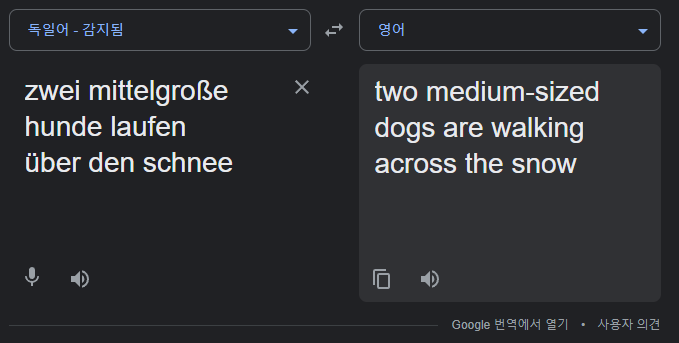

개 두마리가 눈 위를 뛰어간다는 부분은 맞았으나 medium-sized를 steeplechase-haired로 잘못 번역했다.